<b>Universidad Galileo</b><br/>
<b>Maestría de Ciencia de Datos</b><br/>
<b>Statistical Learning I</b><br/>
<b>Jose Godoy</b><br/>
<b>Carnet 22000570</b><br/>
<b>15 de julio 2022</b><br/>

# 1. Cargando librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 2. Cargando set de datos

In [2]:
xls = pd.ExcelFile('estaturas.xlsx')
normales = pd.read_excel(xls, 'normales')
valtest_normales = pd.read_excel(xls, 'valtest(normales)')
valtest_anomalias = pd.read_excel(xls, 'valtest(anomalias)')

Renombrando columnas

In [3]:
normales = pd.DataFrame({"altura": normales.iloc[:,0], "edad": normales.iloc[:,1]})
valtest_normales = pd.DataFrame({"altura": valtest_normales.iloc[:,0], "edad": valtest_normales.iloc[:,1]})
valtest_anomalias = pd.DataFrame({"altura": valtest_anomalias.iloc[:,0], "edad": valtest_anomalias.iloc[:,1]})

Normalización

In [4]:
altura_mean = normales.altura.mean(axis=0)
altura_std = normales.altura.std(axis=0)
edad_mean = normales.edad.mean(axis=0)
edad_std = normales.edad.std(axis=0)

In [5]:
normales_n = normales.copy()
normales_n.altura = (normales.altura-altura_mean)/altura_std
normales_n.edad = (normales.edad-edad_mean)/edad_std

valtest_normales_n = valtest_normales.copy()
valtest_normales_n.altura = (valtest_normales.altura-altura_mean)/altura_std
valtest_normales_n.edad = (valtest_normales.edad-edad_mean)/edad_std

valtest_anomalias_n = valtest_anomalias.copy()
valtest_anomalias_n.altura = (valtest_anomalias.altura-altura_mean)/altura_std
valtest_anomalias_n.edad = (valtest_anomalias.edad-edad_mean)/edad_std

# 3. Algoritmo K-Means

In [6]:
#Indices aleatorios
np.random.seed(2022)

In [7]:
#Algoritmo recursivo
def k_means(k_mean_param, k_mean_set, kparams, contador, ciclo):
    posicion_kparams = kparams.copy()
    longitud = len(k_mean_set)
    #Creando array de distancias y asignación de clusters
    distancias = np.full(longitud, -1.0)
    cluster = np.zeros(longitud)
    #Para cada registro
    for i in range(longitud):
        i_edad = k_mean_set.iloc[i,:].edad
        i_altura = k_mean_set.iloc[i,:].altura
        #Encontrando el centroide más cercano
        for j in range(k_mean_param):
            k_edad = kparams.iloc[j,:].edad
            k_altura = kparams.iloc[j,:].altura
            #Distancia
            distance_k = np.sqrt((k_edad - i_edad) ** 2 + (k_altura - i_altura) ** 2)
            if( distancias[i]==-1 or distancias[i]>distance_k):
                #Distancia más corta
                distancias[i] = distance_k
                cluster[i] = j
    #Reasignando posición de los clusters
    for j in range(k_mean_param):
        kparams.iloc[j,:].edad = k_mean_set["edad"][cluster == j].mean(axis=0)
        kparams.iloc[j,:].altura = k_mean_set["altura"][cluster == j].mean(axis=0)
    #Incrementar el contador si la posición de los clusters es la misma
    if( posicion_kparams.equals(kparams) ):
        contador=contador+1
    #Si la posición de los clusters es la misma dos veces consecutivamente
    if( contador >= 2):
        #Regresar parametros
        return (cluster, kparams, ciclo)
    else:
        #Repetir algoritmo
        return k_means(k_mean_param, k_mean_set, kparams, contador, ciclo + 1)

In [8]:
#Algoritmo kmeans
def k_means_algoritmo(k_mean_param, k_mean_set):
    #Calculando posición de clusters aleatoria
    longitud = len(k_mean_set)
    indices = np.random.choice(longitud, k_mean_param, replace=False)
    kparams = k_mean_set.iloc[indices,:].copy()
    return k_means(k_mean_param, k_mean_set, kparams, 0, 1)

## 3.1. Algoritmo K-Means - Experimento 1, k = 3

Ejecutando algoritmo K-means recursivo:

In [9]:
(cluster, kparams, ciclos) = k_means_algoritmo(3, normales_n)

In [10]:
print("El algoritmo se ejecutó",ciclos,"veces después de 2 iteraciones en el mismo lugar.")

El algoritmo se ejecutó 5 veces después de 2 iteraciones en el mismo lugar.


Clusters encontrados:

In [11]:
kparams.altura = (kparams.altura * altura_std) + altura_mean
kparams.edad = (kparams.edad * edad_std) + edad_mean
print(kparams.reset_index(drop=True))

     altura       edad
0  1.670769  30.692308
1  1.774000  25.450000
2  1.816000  42.800000


Tabla de edades y cluster asignado:

In [12]:
normales_kmeans = normales.copy()
normales_kmeans["cluster"] = cluster
normales_kmeans["cluster_altura"] = np.array(kparams.iloc[cluster,:].altura)
normales_kmeans["cluster_edad"] = np.array(kparams.iloc[cluster,:].edad)
normales_kmeans.head()

,altura,edad,cluster,cluster_altura,cluster_edad
0,1.77,26,1.0,1.774000,25.450000
1,1.74,31,0.0,1.670769,30.692308
2,1.72,24,1.0,1.774000,25.450000
3,1.78,34,1.0,1.774000,25.450000
4,1.65,32,0.0,1.670769,30.692308


Gráfica de puntos

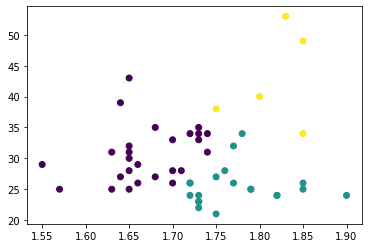

In [13]:
plt.scatter(normales_kmeans.altura, normales_kmeans.edad, alpha=1, c=normales_kmeans.cluster)

## 3.2. Algoritmo K-Means - Experimento 2, k = 4

Ejecutando algoritmo K-means recursivo:

In [22]:
(cluster2, kparams2, ciclos2) = k_means_algoritmo(4, normales_n)

In [24]:
print("El algoritmo se ejecutó",ciclos2,"veces después de 2 iteraciones en el mismo lugar.")

El algoritmo se ejecutó 5 veces después de 2 iteraciones en el mismo lugar.


Clusters encontrados:

In [23]:
kparams2.altura = (kparams2.altura * altura_std) + altura_mean
kparams2.edad = (kparams2.edad * edad_std) + edad_mean
print(kparams2.reset_index(drop=True))

     altura       edad
0  1.667333  29.066667
1  1.773889  24.611111
2  1.754000  37.533333
3  1.583333  26.333333


Tabla de edades y cluster asignado:

In [25]:
normales_kmeans2 = normales.copy()
normales_kmeans2["cluster"] = cluster2
normales_kmeans2["cluster_altura"] = np.array(kparams2.iloc[cluster2,:].altura)
normales_kmeans2["cluster_edad"] = np.array(kparams2.iloc[cluster2,:].edad)
normales_kmeans2.head()

,altura,edad,cluster,cluster_altura,cluster_edad
0,1.77,26,1.0,1.773889,24.611111
1,1.74,31,2.0,1.754000,37.533333
2,1.72,24,1.0,1.773889,24.611111
3,1.78,34,2.0,1.754000,37.533333
4,1.65,32,0.0,1.667333,29.066667


Gráfica de puntos

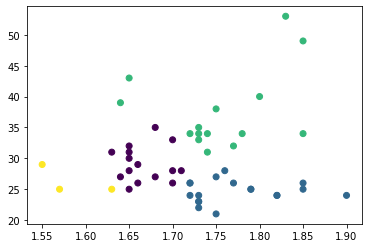

In [26]:
plt.scatter(normales_kmeans2.altura, normales_kmeans2.edad, alpha=1, c=normales_kmeans2.cluster)

## 3.3. Algoritmo K-Means - Experimento 3, k = 5

Ejecutando algoritmo K-means recursivo:

In [27]:
(cluster3, kparams3, ciclos3) = k_means_algoritmo(5, normales_n)

In [28]:
print("El algoritmo se ejecutó",ciclos3,"veces después de 2 iteraciones en el mismo lugar.")

El algoritmo se ejecutó 8 veces después de 2 iteraciones en el mismo lugar.


Clusters encontrados:

In [29]:
kparams3.altura = (kparams3.altura * altura_std) + altura_mean
kparams3.edad = (kparams3.edad * edad_std) + edad_mean
print(kparams3.reset_index(drop=True))

     altura       edad
0  1.833750  25.875000
1  1.826667  47.333333
2  1.730000  25.142857
3  1.720000  35.000000
4  1.636154  28.076923


Tabla de edades y cluster asignado:

In [30]:
normales_kmeans3 = normales.copy()
normales_kmeans3["cluster"] = cluster3
normales_kmeans3["cluster_altura"] = np.array(kparams3.iloc[cluster3,:].altura)
normales_kmeans3["cluster_edad"] = np.array(kparams3.iloc[cluster3,:].edad)
normales_kmeans3.head()

,altura,edad,cluster,cluster_altura,cluster_edad
0,1.77,26,2.0,1.730000,25.142857
1,1.74,31,3.0,1.720000,35.000000
2,1.72,24,2.0,1.730000,25.142857
3,1.78,34,3.0,1.720000,35.000000
4,1.65,32,4.0,1.636154,28.076923


Gráfica de puntos

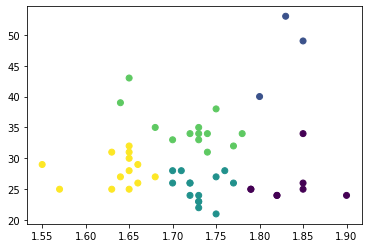

In [31]:
plt.scatter(normales_kmeans3.altura, normales_kmeans3.edad, alpha=1, c=normales_kmeans3.cluster)

## 3.4. Algoritmo K-Means - Experimento 4, k = 6

Ejecutando algoritmo K-means recursivo:

In [32]:
(cluster4, kparams4, ciclos4) = k_means_algoritmo(6, normales_n)

In [33]:
print("El algoritmo se ejecutó",ciclos4,"veces después de 2 iteraciones en el mismo lugar.")

El algoritmo se ejecutó 8 veces después de 2 iteraciones en el mismo lugar.


Clusters encontrados:

In [34]:
kparams4.altura = (kparams4.altura * altura_std) + altura_mean
kparams4.edad = (kparams4.edad * edad_std) + edad_mean
print(kparams4.reset_index(drop=True))

     altura       edad
0  1.753333  34.333333
1  1.636154  28.076923
2  1.840000  51.000000
3  1.656667  39.000000
4  1.831429  24.714286
5  1.730000  25.142857


Tabla de edades y cluster asignado:

In [35]:
normales_kmeans4 = normales.copy()
normales_kmeans4["cluster"] = cluster4
normales_kmeans4["cluster_altura"] = np.array(kparams4.iloc[cluster4,:].altura)
normales_kmeans4["cluster_edad"] = np.array(kparams4.iloc[cluster4,:].edad)
normales_kmeans4.head()

,altura,edad,cluster,cluster_altura,cluster_edad
0,1.77,26,5.0,1.730000,25.142857
1,1.74,31,0.0,1.753333,34.333333
2,1.72,24,5.0,1.730000,25.142857
3,1.78,34,0.0,1.753333,34.333333
4,1.65,32,1.0,1.636154,28.076923


Gráfica de puntos

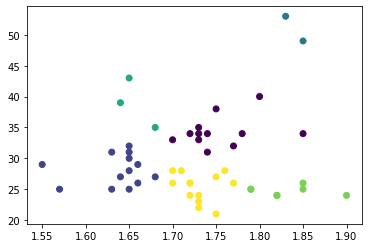

In [36]:
plt.scatter(normales_kmeans4.altura, normales_kmeans4.edad, alpha=1, c=normales_kmeans4.cluster)

## 3.5. Algoritmo K-Means - Experimento 5, k = 2

Ejecutando algoritmo K-means recursivo:

In [37]:
(cluster5, kparams5, ciclos5) = k_means_algoritmo(2, normales_n)

In [38]:
print("El algoritmo se ejecutó",ciclos5,"veces después de 2 iteraciones en el mismo lugar.")

El algoritmo se ejecutó 3 veces después de 2 iteraciones en el mismo lugar.


Clusters encontrados:

In [39]:
kparams5.altura = (kparams5.altura * altura_std) + altura_mean
kparams5.edad = (kparams5.edad * edad_std) + edad_mean
print(kparams5.reset_index(drop=True))

     altura       edad
0  1.770625  29.750000
1  1.649474  29.947368


Tabla de edades y cluster asignado:

In [41]:
normales_kmeans5 = normales.copy()
normales_kmeans5["cluster"] = cluster5
normales_kmeans5["cluster_altura"] = np.array(kparams5.iloc[cluster5,:].altura)
normales_kmeans5["cluster_edad"] = np.array(kparams5.iloc[cluster5,:].edad)
normales_kmeans5.head()

,altura,edad,cluster,cluster_altura,cluster_edad
0,1.77,26,0.0,1.770625,29.750000
1,1.74,31,0.0,1.770625,29.750000
2,1.72,24,0.0,1.770625,29.750000
3,1.78,34,0.0,1.770625,29.750000
4,1.65,32,1.0,1.649474,29.947368


Gráfica de puntos

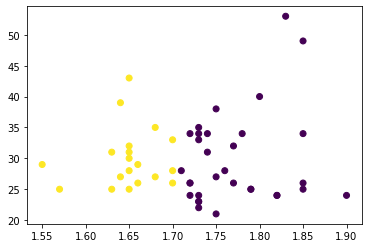

In [42]:
plt.scatter(normales_kmeans5.altura, normales_kmeans5.edad, alpha=1, c=normales_kmeans5.cluster)